In [1]:
import os
import json
import ndjson

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 12})

In [2]:
dataset_name = 'prepared_facebook_data'
folder_name = 'facebook_comm_vol'
DIR_WITH_FILES= f'../other_data_experiments/{folder_name}/third experiment/'
FILES_PARENT_DIR = f'../other_data_experiments/{folder_name}/'
GRAPHS_DIR = f'../other_data_experiments/{folder_name}/graphs/3exp/'

In [3]:
# grid, random and group search without stop:
files=os.listdir(FILES_PARENT_DIR+'first experiment/')
grid_files = [s for s in files if "grid" in s] # files with results for grid search
random_search_files = [s for s in files if "res_rand_prepared" in s] 
group_files = [s for s in files if "groups" in s] 

In [4]:
files=os.listdir(FILES_PARENT_DIR+'third experiment/')
bayes_files = [x for x in files if "bayes_opt" in x]

In [5]:
bayes_group_files = os.listdir(FILES_PARENT_DIR+'third experiment/groups')
bayes_group_files = [x for x in bayes_group_files if "res_BO_groups" in x]

In [6]:
for (array, path) in zip([bayes_files, bayes_group_files], ['third experiment/', 'third experiment/groups/']):
    for file in array:
        df = pd.read_csv(FILES_PARENT_DIR + path + file)
        num=int(file.split(".")[0].split("_")[-1])
        df['run_number']=num
        #df = df.drop(columns=['Unnamed: 0'])
        df.to_csv(FILES_PARENT_DIR+path+file, index = False)

In [7]:
# prepare dataframes:

In [8]:
default_perf = pd.read_csv(FILES_PARENT_DIR+'first experiment/'+f"res_default_{dataset_name}.csv", usecols = [
                                                                     'mean_test_score'])

In [9]:
grid_df=pd.DataFrame([])
for file_name in grid_files:
    df = pd.read_csv(FILES_PARENT_DIR+'first experiment/'+file_name, usecols = ['experiment_name',
                                                                     'mean_test_score'])
    
    df['iter_num']=1
    df.loc[df['experiment_name']!='default params', 
           'iter_num'] = range(1, df.loc[df['experiment_name']!='default params'].shape[0]+1)
    
    grid_df = pd.concat([grid_df, df], sort=False)
    
random_df = pd.DataFrame([])
for file_name in random_search_files:
    file_df = pd.read_csv(FILES_PARENT_DIR+'first experiment/' + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    random_df = pd.concat([random_df, file_df], sort = False)
    
group_df = pd.DataFrame([])
for file_name in group_files:
    file_df = pd.read_csv(FILES_PARENT_DIR+'first experiment/' + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'run_number'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    group_df = pd.concat([group_df, file_df], sort = False)
    
    
bayes_df = pd.DataFrame([])
for file_name in bayes_files:
    file_df = pd.read_csv(DIR_WITH_FILES + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'run_number', 
                                         'mean_fit_time', 'std_fit_time',
                                         'mean_score_time', 'std_score_time'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    file_df['mean_time'] = 3*(file_df['mean_fit_time']+file_df['mean_score_time'])
    
    
#     file_df = file_df.drop(columns = ['mean_fit_time', 
#                                       'mean_score_time',
#                                       'mean_time'])
    bayes_df = pd.concat([bayes_df, file_df], sort = False)


bayes_group_df = pd.DataFrame([])
for file_name in bayes_group_files:
    file_df = pd.read_csv(DIR_WITH_FILES + "groups/" + file_name, 
                              usecols = ['experiment_name', 'mean_test_score',
                                         'run_number', 
                                         'mean_fit_time', 'std_fit_time',
                                         'mean_score_time', 'std_score_time'])
    file_df['iter_num'] = range(1, file_df.shape[0]+1) 
    file_df['mean_time'] = 3*(file_df['mean_fit_time']+file_df['mean_score_time'])
    
#     file_df = file_df.drop(columns = ['mean_fit_time', 'mean_score_time', 'mean_time'])
    bayes_group_df = pd.concat([bayes_group_df, file_df], sort = False)

In [68]:
# get best scores and iter num
def get_best_info(df, name):
    grpby = df.groupby(['run_number', 'experiment_name'])
    best_scores = grpby['mean_test_score'].max().reset_index()
    best_iter = df.merge(best_scores, on =['run_number', 'mean_test_score', 'experiment_name']
                        ).groupby(['run_number', 'experiment_name'])['iter_num'].min().reset_index()
    best_info = best_iter.merge(best_scores)
    best_info['experiment_name']=name
    return best_info
    
best_info = pd.DataFrame([])

all_dfs = [bayes_group_df, bayes_df, 
           random_df, group_df]
names = ['bayes_group_df', 'bayes_df', 
         'random_search', 'random_search_with_groups']
for df, name in zip(all_dfs, names):
    best_info = pd.concat([best_info, get_best_info(df, name)], sort=False)
    for i in df.run_number.unique():    
        df.loc[df.run_number==i, "mean_test_score"] = (
            df.loc[df.run_number==i, "mean_test_score"].copy().cummax()
        )

In [77]:
best_info[best_info.experiment_name=='random_search_with_groups'].groupby(['experiment_name', 'run_number']).max()['iter_num'].max()

719

In [76]:
best_info.experiment_name

0                bayes_group_df
1                bayes_group_df
2                bayes_group_df
3                bayes_group_df
4                bayes_group_df
                ...            
25    random_search_with_groups
26    random_search_with_groups
27    random_search_with_groups
28    random_search_with_groups
29    random_search_with_groups
Name: experiment_name, Length: 80, dtype: object

In [11]:
best_grpby = best_info.groupby(['experiment_name'])
means = best_grpby.mean()
mins = best_grpby.min()
maxs = best_grpby.max()
stds = best_grpby.std()

In [12]:
maxs

,run_number,iter_num,mean_test_score
experiment_name,,,
bayes_df,10,713,0.673705
bayes_group_df,10,688,0.672896
random_search,10,717,0.670112
random_search_with_groups,10,719,0.670311


In [13]:
mins

,run_number,iter_num,mean_test_score
experiment_name,,,
bayes_df,1,176,0.668561
bayes_group_df,1,287,0.667608
random_search,1,145,0.664907
random_search_with_groups,1,521,0.665503


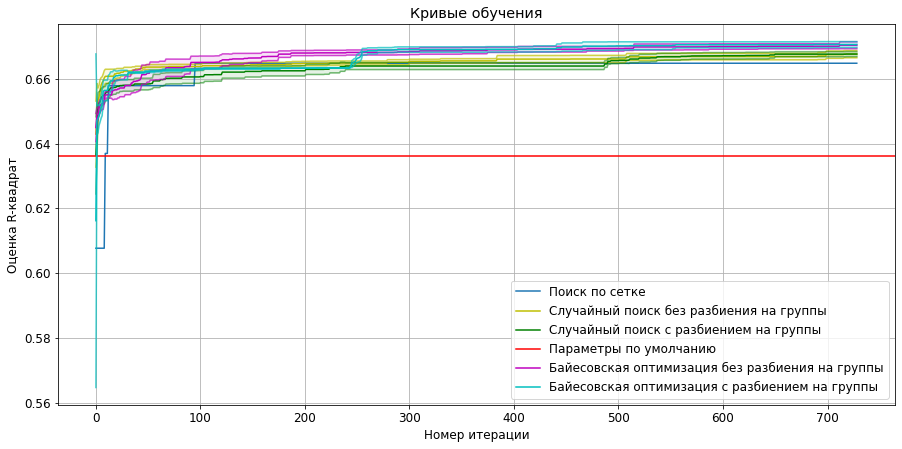

In [14]:
# Data with stop criterion
# stop if the cumulative score hasn't grown in "stop_iter_num" iterations
# GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params',
                      'mean_test_score'].cummax()


## RANDOM_SEARCH
# get best scores per itration for each random_search performance:
# random_df_stopped
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=10
random_std=random_df.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_df.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):
group_std=group_df.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_std=group_std.fillna(0)
group_mean=group_df.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
#default_perf=grid_df.loc[grid_df['experiment_name']=='default params', 'mean_test_score']

## BAYES WITHOUT GROUPS
bo_std=bayes_df.groupby(by="iter_num")['mean_test_score'].std()
bo_std=(bo_std*z)/np.sqrt(n) 
bo_std=bo_std.fillna(0)
bo_mean=bayes_df.groupby(by="iter_num")['mean_test_score'].mean()


## BAYES WITH GROUPS
bo_groups_std=bayes_group_df.groupby(by="iter_num")['mean_test_score'].std()
bo_groups_std=(bo_groups_std*z)/np.sqrt(n) 
bo_groups_std=bo_groups_std.fillna(0)
bo_groups_mean=bayes_group_df.groupby(by="iter_num")['mean_test_score'].mean()

## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#grid plot:
x=list(range(0, grid_perf.shape[0]))
plt.plot(x, grid_perf, label="Поиск по сетке")

#conf for random:
x=list(range(0, random_mean.shape[0]))
plt.plot(x, random_mean, color="y", label="Случайный поиск без разбиения на группы")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
plt.plot(x, group_mean, color="green", label="Случайный поиск с разбиением на группы")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values[0], label="Параметры по умолчанию", color='r')

#conf for bayes opt without groups:
plt.plot(x, bo_mean, color="m", label="Байесовская оптимизация без разбиения на группы")
lower_bo=bo_mean - bo_std
upper_bo=bo_mean + bo_std
plt.plot(x, lower_bo, alpha=0.7, color="m")
plt.plot(x, upper_bo, alpha=0.7, color="m")
plt.fill_between(x, lower_bo, upper_bo, alpha=0.1, color="m") 

#conf for bayes opt wit groups:
plt.plot(x, bo_groups_mean, color="c", label="Байесовская оптимизация с разбиением на группы")
lower_bo_groups=bo_groups_mean - bo_groups_std
upper_bo_groups=bo_groups_mean + bo_groups_std
plt.plot(x, lower_bo_groups, alpha=0.7, color="c")
plt.plot(x, upper_bo_groups, alpha=0.7, color="c")
plt.fill_between(x, lower_bo_groups, upper_bo_groups, alpha=0.1, color="c") 


plt.legend()
plt.title("Кривые обучения")
plt.ylabel("Оценка R-квадрат")
plt.xlabel("Номер итерации")
plt.savefig(GRAPHS_DIR + "learning_curves_without_stop.jpg")
plt.show()

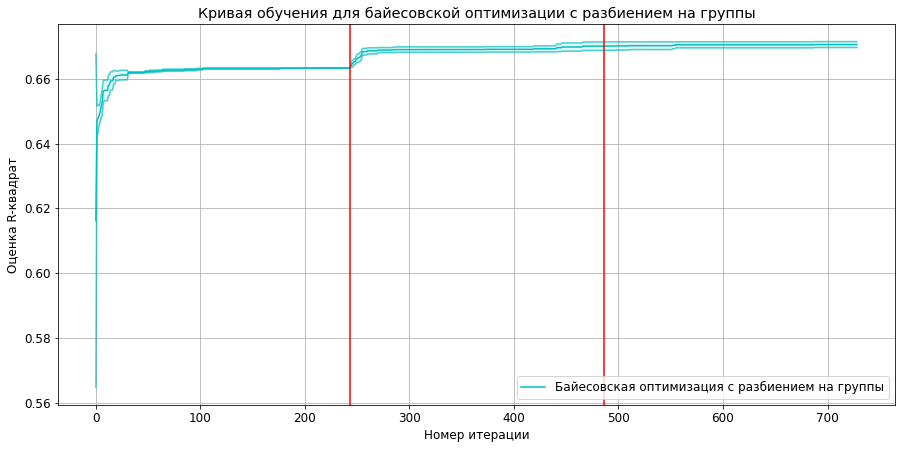

In [15]:
## PLOT
plt.figure(figsize=(15,7))
plt.grid()

#conf for bayes opt wit groups:
plt.plot(x, bo_groups_mean, color="c", label="Байесовская оптимизация с разбиением на группы")
lower_bo_groups=bo_groups_mean - bo_groups_std
upper_bo_groups=bo_groups_mean + bo_groups_std
plt.plot(x, lower_bo_groups, alpha=0.7, color="c")
plt.plot(x, upper_bo_groups, alpha=0.7, color="c")
plt.fill_between(x, lower_bo_groups, upper_bo_groups, alpha=0.1, color="c") 

plt.axvline(243, color='r')
plt.axvline(243*2, color='r')

plt.legend()
plt.title("Кривая обучения для байесовской оптимизации с разбиением на группы")
plt.ylabel("Оценка R-квадрат")
plt.xlabel("Номер итерации")
plt.savefig(GRAPHS_DIR + "bo_group_scores_without_stop.jpg")
plt.show()

In [16]:
print("Upper and lower bounds:")
print("Bayes ", upper_bo[729], lower_bo[729])
print("Group bayes ", upper_bo_groups[729], lower_bo_groups[729])
print("Group random ", upper_group[729], lower_group[729])
print("Random ",upper_random[729], lower_random[729])

Upper and lower bounds:
Bayes  0.6714363586987709 0.6693010727237599
Group bayes  0.6714814964899078 0.6696525987886766
Group random  0.6684137069525022 0.6668586384702233
Random  0.6687238484775194 0.6664958672406426


In [17]:
print("Mean and std:")
print("Bayes ", bo_mean[729], bo_std[729])
print("Group bayes ", bo_groups_mean[729], bo_groups_std[729])
print("Group random ", group_mean[729], group_std[729])
print("Random ",random_mean[729], random_std[729])
print("Grid ", grid_perf.values[-1])
print("default", default_perf.values[0])

Mean and std:
Bayes  0.6703687157112654 0.001067642987505471
Group bayes  0.6705670476392922 0.0009144488506156012
Group random  0.6676361727113628 0.000777534241139441
Random  0.667609857859081 0.0011139906184383945
Grid  0.6647984628183977
default [0.63623226]
